In [1]:
# libraries
import os
import time

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
import sklearn
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold, KFold, RepeatedKFold
from xgboost import XGBRegressor

/home/balde/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
emp = pd.read_csv("employment_status.csv")
ss = pd.read_csv("SampleSubmission.csv")
income = pd.read_csv("income_group.csv")
custom = pd.read_csv("customer.csv")
transaction = pd.read_csv("transactions.csv")

In [3]:
train.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07,"13,500"
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04,"9,000"
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06,"8,000"
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08,"7,000"
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07,"10,400"


In [4]:
test.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,2022-06
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,2022-01
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,2022-05
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,2022-05
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,2022-03


In [5]:
transaction.head()

,TRANSACTION_DESCRIPTION,CUSTOMER_IDENTIFIER,RECORD_DATE,ACCOUNT_TYPE_CODE,ACCOUNT_BALANCE,AMT,EVENT_NUMBER,PRODUCT_CODE,CHANNEL,ACCOUNT_NUMBER,TRANSACTION_REFERENCE
0,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-07-13 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,1857.56,1000.00,11785,SAVE,internet,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
1,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-02-26 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,8843.46,-2000.00,11348,SAVE,internet,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
2,POS PURCHASE,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-07-26 00:00:00+02:00,e92177da406abc0e0a5bce83e853dbdb4e792af521a0ae...,23.82,-199.98,148,CHEQ,system,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,04ae923a903fb07b5c846eb61eda25c4766800f02c2e09...
3,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-03-27 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,198.11,-79.39,11419,SAVE,system,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
4,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-05-06 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,13631.60,-200.00,11528,SAVE,atm,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN


In [6]:
transaction.shape, train.shape

((847544, 11), (3600, 3))

In [7]:
income.head()

,income_group_code,income_group_desc
0,0,NOT SUPPLIED
1,1,R 0 - 499
2,2,R500 - 999
3,3,"R1,000 - 1,999"
4,4,"R2,000 - 2,999"


In [8]:
income.shape

(22, 2)

In [9]:
test.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,2022-06
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,2022-01
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,2022-05
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,2022-05
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,2022-03


## Here we are going to combine train and test set to better proprocess it.

here are few thing to keep in Mind:
    1. Data leakage is something that occurs when we concatinate train and test while separatin them again
    2. We should be careful about the shape of the train and the test on split

## Here I am going to use this method

Add an indicator column while concatenating the two dataframes, so you can later seperate them again:

df = pd.concat([test.assign(ind="test"), train.assign(ind="train")])
Then later you can split them again:

test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")]


from this (Link)['https://datascience.stackexchange.com/questions/81617/how-to-combine-and-separate-test-and-train-data-for-data-cleaning']

we are going to concatinate our train and test data

In [10]:
data = pd.concat([train.assign(ind="train"), test.assign(ind="test")]).reset_index(
    drop=True
)

In [11]:
test.shape, train.shape

((1544, 2), (3600, 3))

In [12]:
data.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME,ind
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07,"13,500",train
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04,"9,000",train
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06,"8,000",train
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08,"7,000",train
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07,"10,400",train


In [13]:
emp.head()

,employee_status_code,employee_status_desc
0,0,Resigned
1,3,Active
2,1,Inactive
3,2,Retiree


In [14]:
custom.head()

,CUSTOMER_IDENTIFIER,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
0,ID_00a7d65f82a6819e79c29a84e805777f0265308b655...,2022-09,1,6,4,7,51
1,ID_09651edcac6c55a5e401062b0c0ef7bbba3f3e49538...,2022-09,0,7,10,3,32
2,ID_17215674e76eb33b47c4dd3ac3392e3e8f1a34b131b...,2022-09,1,7,7,1,41
3,ID_212860dd16c79ea8eae97cc1fc181e6afd4862fceaf...,2022-09,0,13,10,1,44
4,ID_24953f74da44bd0915c4cb78c1d97cbbd66e85bbd91...,2022-08,0,13,6,1,44


In [15]:
ss.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,0
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,0
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,0
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,0
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,0


In [16]:
custom.shape

(5144, 7)

In [17]:
data = data.merge(custom, on="CUSTOMER_IDENTIFIER")
data.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME,ind,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07,"13,500",train,2022-07,0,15,7,1,45
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04,"9,000",train,2022-04,0,15,5,1,32
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06,"8,000",train,2022-08,0,7,7,7,59
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08,"7,000",train,2022-08,1,9,14,7,57
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07,"10,400",train,2022-09,0,12,11,1,29


## We are going to fix the data type of the target variable it's categorical we are converting it into int type
Here there is a problem we notice that there is **,** in our target variable I got help from this one: [Convert to Numerical](https://stackoverflow.com/questions/55557004/getting-attributeerror-float-object-has-no-attribute-replace-error-while)

In [18]:
data["DECLARED_NET_INCOME"] = data["DECLARED_NET_INCOME"].astype(str)
data["DECLARED_NET_INCOME"] = [x.replace(",", "") for x in data["DECLARED_NET_INCOME"]]

In [19]:
data["DECLARED_NET_INCOME"] = data["DECLARED_NET_INCOME"].astype(float)
# data["DECLARED_NET_INCOME"].apply(lambda x: str(x.replace(",", "").strip()))

In [20]:
data.shape

(5144, 10)

In [21]:
data.dtypes

CUSTOMER_IDENTIFIER          object
RECORD_DATE                  object
DECLARED_NET_INCOME         float64
ind                          object
DATE_LAST_UPDATED            object
SEX_CODE                      int64
INCOME_GROUP_CODE             int64
NUMBER_OF_ACCOUNTS            int64
OCCUPATIONAL_STATUS_CODE      int64
AGE                           int64
dtype: object

In [22]:
data["RECORD_DATE"] = pd.to_datetime(data["RECORD_DATE"])
# data["YEAR"] = data["RECORD_DATE"].dt.year
data["MONTH"] = data["RECORD_DATE"].dt.month
# data["DAY"] = data["RECORD_DATE"].dt.day

In [23]:
# converting the target to numeric

# data["DECLARED_NET_INCOME"] = data["DECLARED_NET_INCOME"].astype(float)

In [24]:
data.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME,ind,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,MONTH
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07-01,13500.0,train,2022-07,0,15,7,1,45,7
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04-01,9000.0,train,2022-04,0,15,5,1,32,4
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06-01,8000.0,train,2022-08,0,7,7,7,59,6
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08-01,7000.0,train,2022-08,1,9,14,7,57,8
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07-01,10400.0,train,2022-09,0,12,11,1,29,7


In [25]:
data.tail()

,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME,ind,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,MONTH
5139,ID_dac0d34650b1f449c5a1cf4b99351bd48d0d247126d...,2022-08-01,NaN,test,2022-08,1,13,22,1,33,8
5140,ID_d85982b87631aab9f6f33c9a7460dd2fa738bee8bd4...,2022-04-01,NaN,test,2022-04,0,6,5,1,48,4
5141,ID_c5d07df4daa090d1521749243ac69ee8aecc113639d...,2022-06-01,NaN,test,2022-07,1,14,19,1,41,6
5142,ID_f57b72715ec759cd4ef2e208fdae0ca76a201b33009...,2022-03-01,NaN,test,2022-07,1,13,3,1,22,3
5143,ID_f6ab62b19e6de570ed47944399b39a50b55b7b3ed05...,2022-03-01,NaN,test,2022-07,1,16,6,1,22,3


In [26]:
data.drop(["RECORD_DATE", "DATE_LAST_UPDATED"], axis=1, inplace=True)
data.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME,ind,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,MONTH
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,13500.0,train,0,15,7,1,45,7
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,9000.0,train,0,15,5,1,32,4
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,8000.0,train,0,7,7,7,59,6
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,7000.0,train,1,9,14,7,57,8
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,10400.0,train,0,12,11,1,29,7


In [27]:
test, train = data[data["ind"].eq("test")], data[data["ind"].eq("train")]

In [28]:
train.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME,ind,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,MONTH
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,13500.0,train,0,15,7,1,45,7
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,9000.0,train,0,15,5,1,32,4
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,8000.0,train,0,7,7,7,59,6
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,7000.0,train,1,9,14,7,57,8
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,10400.0,train,0,12,11,1,29,7


In [29]:
train.shape, test.shape

((3600, 9), (1544, 9))

In [30]:
ss.shape

(1544, 2)

In [31]:
X = train.drop(["CUSTOMER_IDENTIFIER", "ind", "DECLARED_NET_INCOME"], axis=1)
y = train["DECLARED_NET_INCOME"]

In [32]:
test = test.drop(["CUSTOMER_IDENTIFIER", "ind", "DECLARED_NET_INCOME"], axis=1)
test.head()

,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,MONTH
3600,1,17,19,1,28,6
3601,0,12,11,1,40,1
3602,0,16,8,1,32,5
3603,1,2,6,1,45,5
3604,0,9,13,1,29,3


In [33]:
X.shape

(3600, 6)

In [34]:
test.head()

,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,MONTH
3600,1,17,19,1,28,6
3601,0,12,11,1,40,1
3602,0,16,8,1,32,5
3603,1,2,6,1,45,5
3604,0,9,13,1,29,3


In [35]:
X.dtypes

SEX_CODE                    int64
INCOME_GROUP_CODE           int64
NUMBER_OF_ACCOUNTS          int64
OCCUPATIONAL_STATUS_CODE    int64
AGE                         int64
MONTH                       int64
dtype: object

In [36]:
test.dtypes

SEX_CODE                    int64
INCOME_GROUP_CODE           int64
NUMBER_OF_ACCOUNTS          int64
OCCUPATIONAL_STATUS_CODE    int64
AGE                         int64
MONTH                       int64
dtype: object

In [37]:
y.dtypes

dtype('float64')

In [1]:
params = {
    "objective": "tweedie",
    "metric": "rmse",
    "learning_rate": 0.01,
    "sub_feature": 0.8,
    "sub_row": 0.75,
    "bagging_freq": 1,
    "lambda_l2": 0.6,
    "verbosity": 1,
    "num_iterations": 5000,
    "num_leaves": 128,
    "min_data_in_leaf": 50,
}

In [39]:
%%time
errcb = []
y_pred_totcb = []
fold = KFold(n_splits=10, shuffle=True, random_state=42)
i = 1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params)
    # m = CatBoostRegressor()
    # m = XGBRegressor()
    m.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100,
        early_stopping_rounds=200,
    )
    preds = m.predict(X_test)
    print("err: ", metrics.mean_squared_error(y_test, preds, squared=False))
    errcb.append(metrics.mean_squared_error(y_test, preds, squared=False))
    p = m.predict(test)
    y_pred_totcb.append(p)

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 11225.1	valid_1's rmse: 11144.2
[LightGBM] [Warning] No further splits with 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 11440.5	valid_1's rmse: 11563.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set with sub_feature=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set with sub_row=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Start training from score 25000.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [40]:
np.mean(np.log1p(errcb))

9.231092470577707

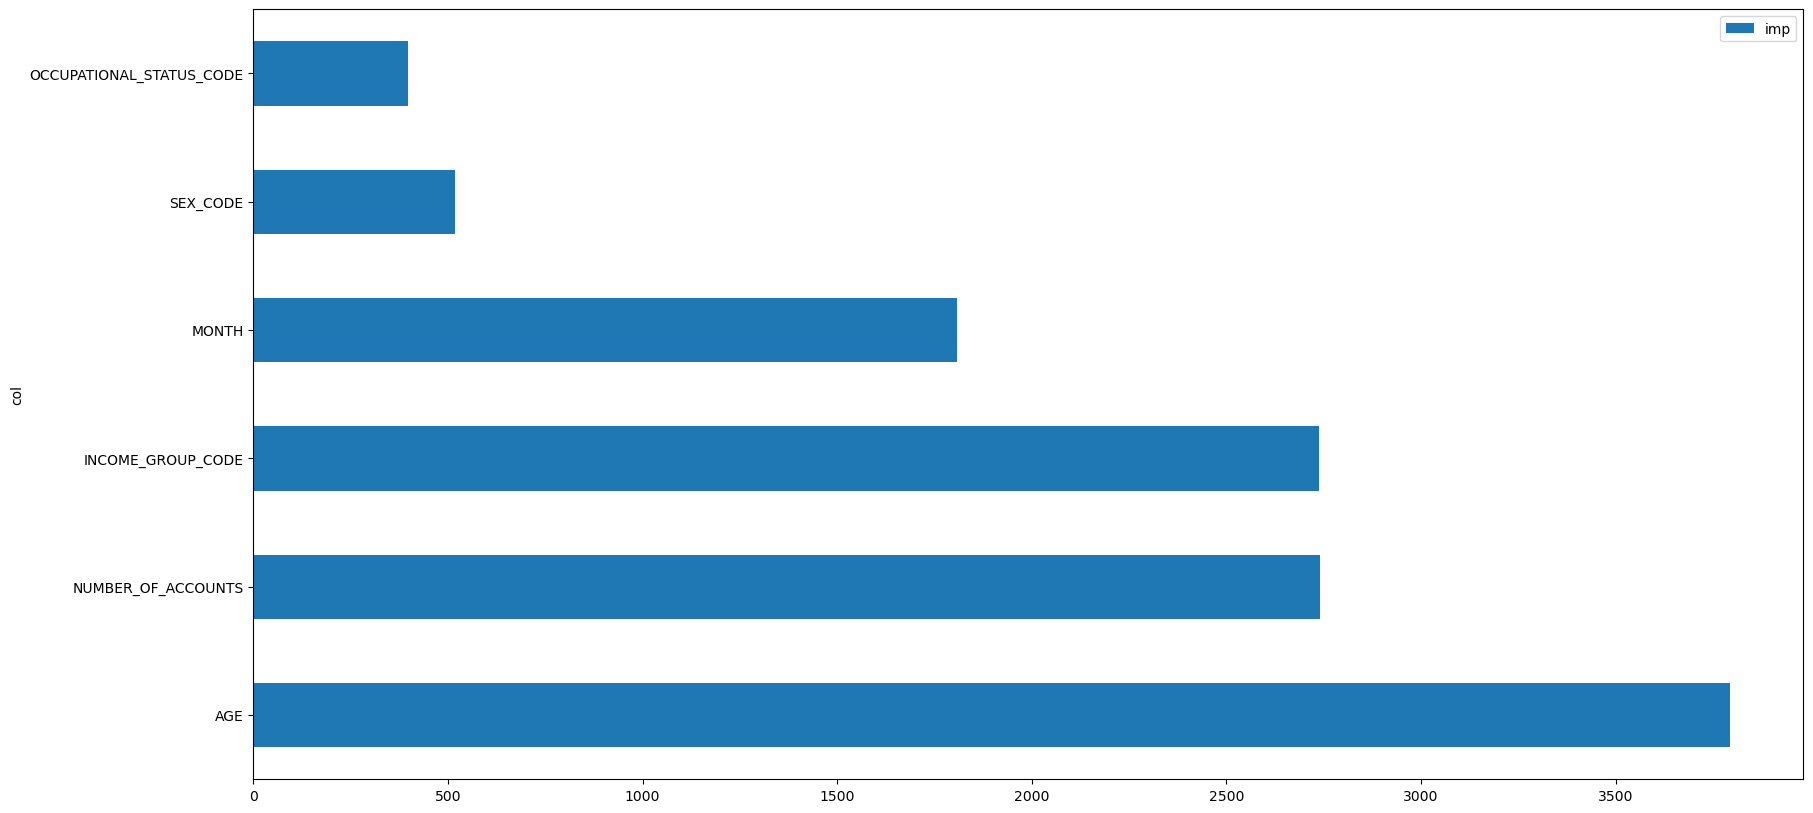

In [41]:
fea_imp = pd.DataFrame({"imp": m.feature_importances_, "col": X.columns})
fea_imp = fea_imp.sort_values(["imp", "col"], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind="barh", x="col", y="imp", figsize=(20, 10))
plt.savefig("catboost_feature_importance.png")

In [42]:
np.mean(y_pred_totcb, 0)

array([37290.67794261, 13081.99311296, 30866.06974591, ...,
       22969.15849883, 14910.52900443, 30028.28909264])

In [43]:
len(np.mean(y_pred_totcb, 0))

1544

In [44]:
test["DECLARED_NET_INCOME"] = np.mean(y_pred_totcb, 0)

In [45]:
ss.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,0
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,0
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,0
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,0
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,0


In [46]:
ss["DECLARED_NET_INCOME"] = np.mean(y_pred_totcb, 0)
ss.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,37290.677943
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,13081.993113
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,30866.069746
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,21899.482366
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,12465.606257


### transforming the prediction


In [47]:
ss["DECLARED_NET_INCOME"] = np.log1p(abs(ss["DECLARED_NET_INCOME"]))

In [48]:
ss.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,10.526525
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,9.479068
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,10.337445
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,9.994264
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,9.430809


In [49]:
ss.to_csv("base_lgb.csv", index=False)